End to end screen recognition requires some  postprocessing on the model outputs to format them for screen reader use cases. This notebook shows how we can add more metadata on top of the detected UI objects (icon classes) and format them for downstream use cases (e.g., to send to screen reader or to feed into an LLM, etc.). 

In [1]:
import os
import sys
import json
import warnings

from collections import namedtuple, defaultdict
warnings.simplefilter(action='ignore', category=FutureWarning)

from PIL import ImageDraw
from screenrecognition.ui_datasets import *
from screenrecognition.ui_models import *
import torch
import datetime

In [2]:
CHECKPOINTS_DIR = "./downloads/checkpoints/"
PREDICTIONS_DIR = "./predictions/"
GROUND_TRUTH_DIR = "./ground_truth/"
MAX_UNION_VALUE = sys.float_info.max

In [3]:
CHECKPOINT_TO_EVALUATE = "screenrecognition-web350k-vins.ckpt"

## Helper functions

In [4]:
def drawBoxesOnImage(test_image, boxes, labels, idx2Label, scores=[], display_width=400):     
    # Resize the image to be more visible in the cell 
    wpercent = (400/float(test_image.size[0]))
    hsize = int((float(test_image.size[1])*float(wpercent)))
    test_image = test_image.resize((400, hsize))

    draw = ImageDraw.Draw(test_image)

    conf_thresh = 0.5
    for i in range(len(boxes)):
        conf_score = 100 
        if len(scores) > 0: 
            conf_score = scores[i]
            
        if conf_score > conf_thresh:
            x1, y1, x2, y2 = boxes[i]
            x1 = int(x1) * wpercent
            y1 = int(y1) * wpercent
            x2 = int(x2) * wpercent
            y2 = int(y2) * wpercent
            draw.rectangle([x1, y1, x2, y2], outline='red')
            draw.text((x1, y1), idx2Label[str(int(labels[i]))] + " {:.2f}".format(float(conf_score)), fill="red")
    return test_image

In [5]:
def drawUIObjectsOnImage(test_image, uiObjects, displayWidth=400): 
     # Resize the image to be more visible in the cell 
    wpercent = (400/float(test_image.size[0]))
    hsize = int((float(test_image.size[1])*float(wpercent)))
    test_image = test_image.resize((400, hsize))

    draw = ImageDraw.Draw(test_image)

    conf_thresh = 0.5
    for i in range(len(uiObjects)):
        uiObject = uiObjects[i]
        if uiObject.confidence > conf_thresh:
            x1 = int(uiObject.x) * wpercent
            y1 = int(uiObject.y) * wpercent
            x2 = int(uiObject.x + uiObject.width) * wpercent
            y2 = int(uiObject.y + uiObject.height) * wpercent
            draw.rectangle([x1, y1, x2, y2], outline='red')
            draw.text((x1, y1), f"{uiObject.label} {uiObject.text} {uiObject.confidence:.2f}", fill="red")
    return test_image

In [6]:
def loadModel(): 
    model_path = os.path.join(CHECKPOINTS_DIR,  CHECKPOINT_TO_EVALUATE)
    m = UIElementDetector.load_from_checkpoint(model_path).eval()
    return m

In [7]:
def loadClassMap(): 
    class_map_file = "metadata/screenrecognition/class_map_vins_manual.json"
    with open(class_map_file, "r") as f:
        class_map = json.load(f)
        
    idx2Label = class_map['idx2Label']
    return idx2Label

In [8]:
def getPredictionsForImage(model, image): 
    img_input = image
    if not torch.is_tensor(image):
        img_transforms = transforms.ToTensor()  
        img_input = img_transforms(image)
    
    pred = model.model([img_input])
    return pred

## Evaluation

First, load the model and image. We will use the model to get the predictions for the screenshot, and then format them. 

In [9]:
test_image = Image.open("2916.jpg")
model = loadModel()

Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file downloads/checkpoints/screenrecognition-web350k-vins.ckpt`


In [10]:
pred = getPredictionsForImage(model, test_image)

### Visualize the output boxes on a screenshot

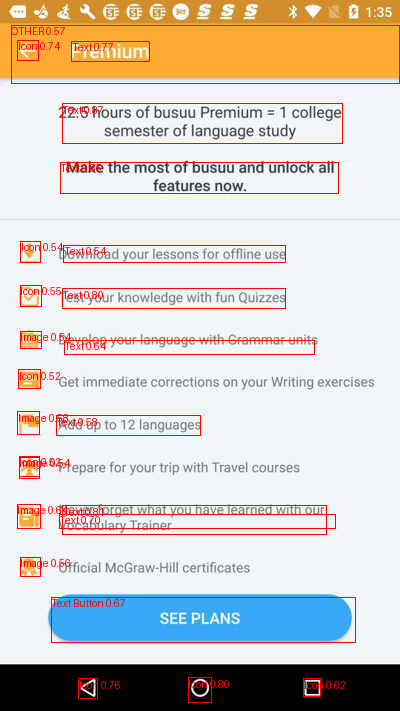

In [11]:
boxes =  pred[0]['boxes']
scores = pred[0]['scores']
labels = pred[0]['labels']
idx2Label = loadClassMap()
image = drawBoxesOnImage(test_image, boxes, labels, idx2Label, scores)
image

### For each detected object, create a user friendly UIObject class to represent the element metadata to the screen reader.
The UIObject class defines a bounding box for each element, it's `label` (UI element class), it's `confidence` score from the model output, it's `text` which can be added using OCR, and it's `clickable` value. In this notebook, we will only add the icon classes to the UIObjects, and skip over OCR and clickability for time. `clickable` is used by screen readers to determine whether to announce any UI element as a `button` type that can be interacted with vs a non-interactive UI element. Screen Recognition also uses OCR to postprocess detected UI elements and add their corresponding text.  

In [12]:
class UIObject: 
    def __init__(self, x1, y1, x2, y2, label, confidence=1.0, text="", clickable=True): 
        self.x = x1 
        self.y = y1 
        self.width = x2 - x1 
        self.height = y2 - y1 
        self.label = label 
        self.text = text 
        self.confidence = confidence
        self.clickable = clickable # Whether or not the UI element is interactive

    def to_str(self): 
        return f"UIObject Box: {self.x:.2f}, {self.y:.2f}, {self.width:.2f}, {self.height:.2f},  Class: {self.label},  Label: {self.text}, Score: {self.confidence}"

In [13]:
uiObjects = []
for i in range(len(boxes)): 
    score = scores[i]
    box = boxes[i].tolist()
    label = labels[i] 
    classStr = idx2Label[str(int(label))]
    uiObject = UIObject(box[0], box[1], box[2], box[3], classStr, confidence=score) 
    uiObjects.append(uiObject)

In [14]:
[uiObj.to_str() for uiObj in uiObjects]

['UIObject Box: 84.06, 140.76, 379.27, 53.24,  Class: Text,  Label: , Score: 0.8696362972259521',
 'UIObject Box: 81.29, 219.54, 376.44, 41.89,  Class: Text,  Label: , Score: 0.8539764881134033',
 'UIObject Box: 85.74, 683.45, 355.30, 38.74,  Class: Text,  Label: , Score: 0.8078359961509705',
 'UIObject Box: 254.79, 915.26, 30.75, 32.78,  Class: Icon,  Label: , Score: 0.801960289478302',
 'UIObject Box: 84.78, 390.92, 301.44, 26.06,  Class: Text,  Label: , Score: 0.8008185625076294',
 'UIObject Box: 97.44, 56.43, 105.32, 26.97,  Class: Text,  Label: , Score: 0.7717123627662659',
 'UIObject Box: 106.33, 916.38, 24.89, 27.34,  Class: Icon,  Label: , Score: 0.7633839845657349',
 'UIObject Box: 24.98, 54.32, 27.21, 27.26,  Class: Icon,  Label: , Score: 0.7419789433479309',
 'UIObject Box: 80.17, 694.48, 372.86, 19.58,  Class: Text,  Label: , Score: 0.7009962201118469',
 'UIObject Box: 69.30, 806.61, 410.89, 60.50,  Class: Text Button,  Label: , Score: 0.6675175428390503',
 'UIObject Box: 2

### For each detected Icon class, get a description
You can train an Icon classsification model (as in the Screen Recognition paper), or
use an existing model like Clip to classify the image data by giving it a set of icon classes. In this example, we will use zero shot icon classification from Clip to detect the classes. It's not the most accurate method, but gives one way this can be done. 

In [14]:
from transformers import CLIPProcessor, CLIPModel

In [15]:
# Download the CLIP model weights and initialize the model. To use the below model, accept the agreement on the model card here: https://huggingface.co/openai/clip-vit-base-patch32 
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [17]:
# Extract out the Icon sub images from the PIL image by cropping 
icon_indices = []
icon_images = []
for i in range(len(uiObjects)): 
    uiObject = uiObjects[i] 
    if uiObject.label == "Icon":
        icon_indices.append(i)
        
        # Crop the Icon box out of the image
        right = uiObject.x + uiObject.width 
        bottom = uiObject.y + uiObject.height
        im1 = test_image.crop((int(uiObject.x), int(uiObject.y), int(right), int(bottom)))
        icon_images.append(im1)

In [18]:
# Define the class you want to use for the classification. Experiment with various labels to get the best results. 
classes = ['circle', 'square', 'play', 'pause', 'home', 'arrow', 'back', 'books', 'check', 'paper']

# Get the processor inputs. 
inputs = processor(text=classes, images=icon_images, return_tensors="pt", padding=True, do_convert_rgb=False)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

### Visualize icon descriptions

we can visualize each extracted icon below along with its corresponding icon type. 

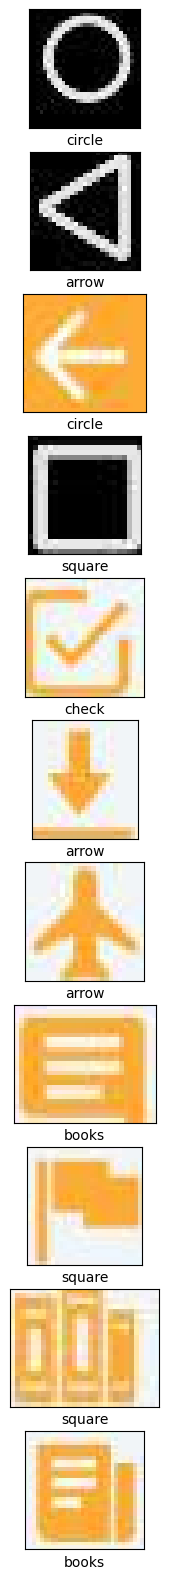

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 20))

icon_labels = []
for idx in range(len(icon_images)):

    # show original image
    icon_probs = list(probs[idx].detach().numpy())
    max_icon_index = icon_probs.index(max(icon_probs))
    max_class = classes[max_icon_index]
    icon_labels.append(max_class)

    fig.add_subplot(len(icon_images), 2, 2*(idx+1)-1)
    plt.xlabel(max_class)
    plt.imshow(icon_images[idx])
    plt.xticks([])
    plt.yticks([])


plt.show()

#### Add the top Icon class back to the UIObject 
Now that we have our icon labels, let's add them back to the UIObject classes. 

In [20]:
for i in range(len(icon_labels)): 
    icon_label = icon_labels[i]
    icon_index = icon_indices[i]
    icon_object = uiObjects[icon_index]
    icon_object.text = icon_label

[uiObj.to_str() for uiObj in uiObjects]

['UIObject Box: 84.06, 140.76, 379.27, 53.24,  Class: Text,  Label: , Score: 0.8696362972259521',
 'UIObject Box: 81.29, 219.54, 376.44, 41.89,  Class: Text,  Label: , Score: 0.8539764881134033',
 'UIObject Box: 85.74, 683.45, 355.30, 38.74,  Class: Text,  Label: , Score: 0.8078359961509705',
 'UIObject Box: 254.79, 915.26, 30.75, 32.78,  Class: Icon,  Label: circle, Score: 0.801960289478302',
 'UIObject Box: 84.78, 390.92, 301.44, 26.06,  Class: Text,  Label: , Score: 0.8008185625076294',
 'UIObject Box: 97.44, 56.43, 105.32, 26.97,  Class: Text,  Label: , Score: 0.7717123627662659',
 'UIObject Box: 106.33, 916.38, 24.89, 27.34,  Class: Icon,  Label: arrow, Score: 0.7633839845657349',
 'UIObject Box: 24.98, 54.32, 27.21, 27.26,  Class: Icon,  Label: circle, Score: 0.7419789433479309',
 'UIObject Box: 80.17, 694.48, 372.86, 19.58,  Class: Text,  Label: , Score: 0.7009962201118469',
 'UIObject Box: 69.30, 806.61, 410.89, 60.50,  Class: Text Button,  Label: , Score: 0.6675175428390503',


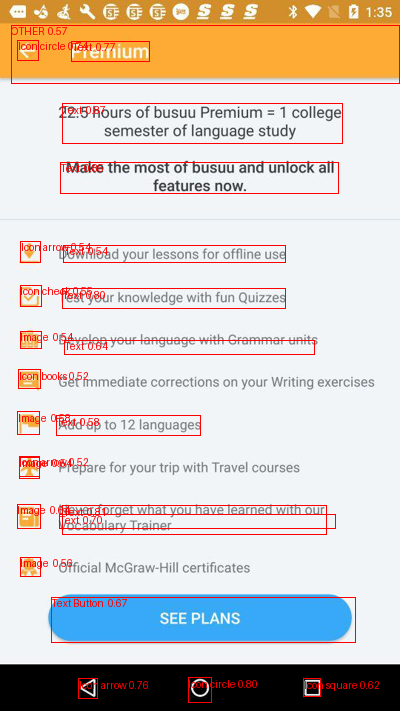

In [21]:
test_image = Image.open("2916.jpg")
drawUIObjectsOnImage(test_image, uiObjects)

#### Add OCR text for everything else. 

In [22]:
# For the screen reader to be able to read the text, we should also run OCR here for each UI element to add the text
# For sake of time, not going to do that today, but you can use pytesseract to do that later as a bonus. 

### Grouping and ordering the detected uiObjects. 

In [23]:
# Finally, Screen Recognition groups and orders the detected UI objects for the screen reader use case. 
# e.g., text lines into paragraphs, images with text below, etc. 
# That grouping makes them more usable as higher level components vs the raw individual detected UI element classes. 

#### Feel free to read more on how this works here: 
Screen Recognition: https://dl.acm.org/doi/pdf/10.1145/3411764.3445186